In [11]:
import cv2
import easyocr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import re



In [12]:

# def extract_frame(video_path, frame_number=0):
#     # Open the video file
#     cap = cv2.VideoCapture(video_path)
    
#     # Check if video opened successfully
#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         return
    
#     # Get video properties
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     fps = cap.get(cv2.CAP_PROP_FPS)
    
#     # print(f"Total frames: {total_frames}")
#     # print(f"FPS: {fps}")
    
#     # Set frame position
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
#     # Read frame
#     ret, frame = cap.read()
    
#     if not ret or frame is None:
#         print("Error: Could not read frame.")
#         return None, total_frames, fps
    
#     # Release video capture object
#     cap.release()

#     return frame, total_frames, fps

# ...existing code...
import math
from tqdm.auto import tqdm

def extract_frame(video_path, frame_number=0):
    # Try multiple OpenCV backends
    cap = None
    for backend in (cv2.CAP_ANY, cv2.CAP_FFMPEG, cv2.CAP_GSTREAMER):
        try:
            cap = cv2.VideoCapture(video_path) if backend == cv2.CAP_ANY else cv2.VideoCapture(video_path, backend)
            if cap.isOpened():
                break
            cap.release()
            cap = None
        except Exception:
            cap = None

    if cap is None or not cap.isOpened():
        tqdm.write(f"[WARN] Could not open video: {video_path}")
        return None, None, None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    try:
        if math.isnan(fps):
            fps = 0.0
    except Exception:
        pass

    # Clamp requested frame into range
    if total_frames > 0 and frame_number >= total_frames:
        frame_number = max(0, total_frames - 1)

    if frame_number > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = cap.read()

    if not ret or frame is None:
        # Fallback: read first frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        ret, frame = cap.read()

    cap.release()

    if not ret or frame is None:
        tqdm.write(f"[WARN] Could not read a frame from: {video_path}")
        return None, (total_frames or None), (fps or None)

    return frame, total_frames, fps
# ...existing code...
# Usage examples
video_path = '/cosma5/data/durham/dc-fras4/ultrasound/SLURP/MFT_videos/MFT 001/Scan 2/Image188.avi'

# Extract single frame (frame 10)
frame, total_frames, fps = extract_frame(video_path, 10)


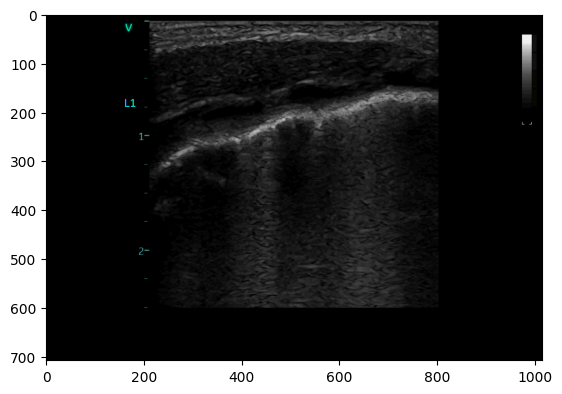

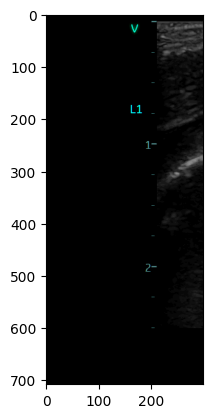

In [13]:

plt.imshow(frame)
plt.show()


frame_cut = frame[:,:300]
plt.imshow(frame_cut)



In [14]:
import easyocr
import cv2
import numpy as np

def read_text(image_path, min_confidence=0.0, reader=None):
    # Initialize reader for English only
    if reader is None:
        reader = easyocr.Reader(['en'], gpu=True, verbose=False)

    if not isinstance(image_path, np.ndarray):
        # Read image

        image = cv2.imread(image_path)
    else:
        image = image_path
    
    # Perform OCR - lowered text_threshold to catch more detections
    results = reader.readtext(
        image,
        detail=1,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789/',
        text_threshold=0.1,  # Lower threshold to catch more text
        paragraph=False
    )
    
    # Draw results on image and print text
    detected_texts = []
    for (bbox, detected_text, prob) in results:
        # Only include results above minimum confidence
        if prob >= min_confidence:
            detected_texts.append((detected_text, prob))
        # print(f"Text: {detected_text} (Confidence: {prob:.2f})")
    
    # Display result
    # cv2.imshow("Result", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return detected_texts

# Usage
image_path = frame_cut
read_text(image_path, min_confidence=0.3)  # Set to 0.0 to see all detections

/cosma/home/durham/dc-fras4/.conda/envs/LUS/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[('Li', np.float64(0.40958253759740443))]

In [15]:
# get scan label from detected texts
# detected_texts = read_text(image_path, min_confidence=0.0)
# scan_label = None
possibilities = ['R1', 'R2', 'R3', 'R4', 'R5', 'L1', 'L2', 'L3', 'L4', 'L5', 'Right1', 'Right2', 'Right3', 'Right4', 'Right5',
                 'Left1', 'Left2', 'Left3', 'Left4', 'Left5']

def find_scan_label(detected_texts, possibilities):
    possibilities_upper = [p.upper() for p in possibilities]
    for text, prob in detected_texts:
        text_upper = text.upper()
        if text_upper in possibilities_upper:
            if prob >= 0.4:  # confidence threshold
                return text
    return None



In [16]:


# Set the directory path
dir_path = r'/cosma5/data/durham/dc-fras4/ultrasound/SLURP/MFT_videos'

# Diagnostics
print(f"Directory exists: {os.path.exists(dir_path)} -> {dir_path}")
if os.path.exists(dir_path):
    try:
        print("Sample entries:", os.listdir(dir_path)[:5])
    except Exception as e:
        print("Could not list directory contents:", e)

# Create an empty list to store the file names and paths
file_list = []

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(dir_path):
    files = [ fi for fi in files if fi.endswith(".avi") or fi.endswith(".mp4") ]
    for file in tqdm(files, desc=f"Indexing videos in {os.path.basename(root)}", leave=False):
        # Get the file path
        file_path = os.path.join(root, file)
        scan_filename = os.path.split(os.path.dirname(file_path))[-1]
        re_match = re.search(r'[1-4]', scan_filename)
        scan_no = f'LUS_{re_match.group(0)}' if re_match else 'LUS_Unknown'
        patient_id_filename = os.path.split(os.path.dirname(os.path.dirname(file_path)))[-1]
        re_match_1 = re.search(r'[0-9][0-9][0-9]', patient_id_filename)
        patient_id = re_match_1.group(0) 
        # Append the file name and path to the list
        file_list.append({'Hospital': 'MFT', 'File Path': file_path, 'Patient ID': patient_id, 'Scan No': scan_no})

ocr_reader = easyocr.Reader(['en'], gpu=True, verbose=False)

# add scan label column
for file_info in tqdm(file_list, desc="Extracting scan labels (OCR)"):
    video_path = file_info['File Path']
    frame, total_frames, fps = extract_frame(video_path, frame_number=10)
    frame_cut = frame[:,:300] if frame is not None else None

    file_info['Total Frames'] = total_frames or 0
    file_info['FPS'] = fps or 0.0

    if frame is None:
        file_info['Scan Label'] = 'Unknown'
        file_info['Read Error'] = True
        continue

    

    detected_texts = read_text(frame_cut, min_confidence=0.0, reader=ocr_reader)
    scan_label = find_scan_label(detected_texts, possibilities)
    file_info['Scan Label'] = scan_label if scan_label else 'Unknown'

    if file_info['Scan No'] == 'LUS_4':
        file_info['Scan No'] = 'LU_4'


# Create a Pandas DataFrame from the list
df_path = pd.DataFrame(file_list)


Directory exists: True -> /cosma5/data/durham/dc-fras4/ultrasound/SLURP/MFT_videos
Sample entries: ['MFT 007', 'MFT 035', 'MFT 014', 'MFT 026', 'MFT 021']


Indexing videos in MFT_videos: 0it [00:00, ?it/s]

Indexing videos in MFT 007: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 3 :   0%|          | 0/21 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/19 [00:00<?, ?it/s]

Indexing videos in Day 4: 0it [00:00, ?it/s]

Indexing videos in MFT 035: 0it [00:00, ?it/s]

Indexing videos in Day 4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 014: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 026: 0it [00:00, ?it/s]

Indexing videos in Day 3:   0%|          | 0/7 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/6 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/7 [00:00<?, ?it/s]

Indexing videos in MFT 021: 0it [00:00, ?it/s]

Indexing videos in Day 4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 019: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/23 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/24 [00:00<?, ?it/s]

Indexing videos in MFT 013: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 032: 0it [00:00, ?it/s]

Indexing videos in Day 3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 004: 0it [00:00, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 1: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in MFT 036: 0it [00:00, ?it/s]

Indexing videos in Day 4: 0it [00:00, ?it/s]

Indexing videos in Day 2 : 0it [00:00, ?it/s]

Indexing videos in Day 3 empty_: 0it [00:00, ?it/s]

Indexing videos in Day 1: 0it [00:00, ?it/s]

Indexing videos in MFT 017: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 025: 0it [00:00, ?it/s]

Indexing videos in day 3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in MFT 022: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 028: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 010: 0it [00:00, ?it/s]

Indexing videos in DAY 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in DAY 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in DAY 3:   0%|          | 0/9 [00:00<?, ?it/s]

Indexing videos in DAY 4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 031: 0it [00:00, ?it/s]

Indexing videos in Day 3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 009: 0it [00:00, ?it/s]

Indexing videos in DAY 2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in DAY 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in DAY 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in DAY 4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 003: 0it [00:00, ?it/s]

Indexing videos in scan 3:   0%|          | 0/21 [00:00<?, ?it/s]

Indexing videos in scan 2 :   0%|          | 0/23 [00:00<?, ?it/s]

Indexing videos in Scan 1: 0it [00:00, ?it/s]

Indexing videos in Scan 4:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in MFT 033: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 001: 0it [00:00, ?it/s]

Indexing videos in Scan 3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Scan 4:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Scan 1:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Scan 2:   0%|          | 0/18 [00:00<?, ?it/s]

Indexing videos in MFT 020: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 012: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/28 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/21 [00:00<?, ?it/s]

Indexing videos in MFT 018: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in MFT 015: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/30 [00:00<?, ?it/s]

Indexing videos in MFT 027: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 006: 0it [00:00, ?it/s]

Indexing videos in Day 4:   0%|          | 0/17 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/20 [00:00<?, ?it/s]

Indexing videos in MFT 034: 0it [00:00, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 030: 0it [00:00, ?it/s]

Indexing videos in Day 4:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 3 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in MFT 002: 0it [00:00, ?it/s]

Indexing videos in Scan 4:   0%|          | 0/28 [00:00<?, ?it/s]

Indexing videos in scan 2:   0%|          | 0/21 [00:00<?, ?it/s]

Indexing videos in Scan 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in scan 3:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in MFT 008: 0it [00:00, ?it/s]

Indexing videos in Day 3:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in MFT 029: 0it [00:00, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in MFT 023: 0it [00:00, ?it/s]

Indexing videos in Day 4:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in MFT 011: 0it [00:00, ?it/s]

Indexing videos in Day 4:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/19 [00:00<?, ?it/s]

Indexing videos in MFT 016: 0it [00:00, ?it/s]

Indexing videos in day 1:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in Day 2:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in day 3:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing videos in day 4:   0%|          | 0/28 [00:00<?, ?it/s]

Indexing videos in MFT 024: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/10 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/11 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in Day 4 :   0%|          | 0/13 [00:00<?, ?it/s]

Indexing videos in MFT 005: 0it [00:00, ?it/s]

Indexing videos in Day 2:   0%|          | 0/16 [00:00<?, ?it/s]

Indexing videos in Day 1:   0%|          | 0/12 [00:00<?, ?it/s]

Indexing videos in Day 3:   0%|          | 0/22 [00:00<?, ?it/s]

Indexing videos in Day 4:   0%|          | 0/15 [00:00<?, ?it/s]

Indexing videos in MFT 037: 0it [00:00, ?it/s]

Indexing videos in Day 3 empty_: 0it [00:00, ?it/s]

Indexing videos in Day 1: 0it [00:00, ?it/s]

Indexing videos in Day 2 empty_: 0it [00:00, ?it/s]

Indexing videos in Day 4: 0it [00:00, ?it/s]

Extracting scan labels (OCR):   0%|          | 0/1788 [00:00<?, ?it/s]

In [17]:
print(df_path)

     Hospital                                          File Path Patient ID  \
0         MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        007   
1         MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        007   
2         MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        007   
3         MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        007   
4         MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        007   
...       ...                                                ...        ...   
1783      MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        005   
1784      MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        005   
1785      MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        005   
1786      MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        005   
1787      MFT  /cosma5/data/durham/dc-fras4/ultrasound/SLURP/...        005   

     Scan No  Total Frames        FPS Scan Label  


In [18]:
# Change scan label to expert scan label
def to_expert_label(label: str) -> str:
    s = str(label).upper()
    if s in ("R3", "RIGHT3"):
        return "Rax"
    if s in ("R1", "RIGHT1"):
        return "RAA"
    if s in ("R2", "RIGHT2"):
        return "RAB"
    if s in("R4", "RIGHT4"):
        return "RPA"
    if s in("R5", "RIGHT5"):
        return "RPB"
    if s in ("L1", "LEFT1"):
        return "LAA"
    if s in ("L2", "LEFT2"):
        return "LAB"
    if s in ("L3", "LEFT3"):
        return "LAX"
    if s in ("L4", "LEFT4"):
        return "LPA"
    if s in ("L5", "LEFT5"):
        return "LPB"
    return label

df_path["Scan Label"] = df_path["Scan Label"].apply(to_expert_label)

In [19]:
# Add score
scores_directory = '/cosma7/data/dp004/rrtx34/ultrasound/Virginie_scores/Scores_Medway'

def add_scores(df, scores_directory):
    # find patient score file
    for i in tqdm(df.index, desc="Adding scores"):
        patient_id = df.at[i, 'Patient ID']
        scan_no = df.at[i, 'Scan No']
        scan_label = df.at[i, 'Scan Label']

        df_score = None
        for file in os.listdir(scores_directory):
            if file.endswith(f"{patient_id}.xlsx"):
                df_score = pd.ExcelFile(os.path.join(scores_directory, file))
                sheets = df_score.sheet_names
                df_score = pd.read_excel(df_score, sheet_name=sheets[-1])
                break
        if df_score is None:
            continue
        # clean score data frames to remove empty rows and columns
        for col in df_score.columns:
            if df_score[col].isnull().all():
                df_score = df_score.drop(columns=[col])

        for index, row in df_score.iterrows():
            if row.isnull().all():
                df_score = df_score.drop(index=index)

        # make first row and column header
        df_score.columns = df_score.iloc[0]
        df_score = df_score[1:]
        df_score = df_score.set_index(df_score.columns[0])

        # add score to main dataframe
        if scan_label in df_score.index and scan_no in df_score.columns:
            score = df_score.at[scan_label, scan_no]
            df.at[i, 'Score'] = score

    return df
        
df_path = add_scores(df_path, scores_directory)
                

Adding scores:   0%|          | 0/1788 [00:00<?, ?it/s]

/tmp/ipykernel_3413539/832672747.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NI' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'Score'] = score


In [20]:
df_path.to_csv('MFT_data.csv', index=False)

In [22]:
df_loaded = pd.read_csv('MFT_data.csv')
unknown_scan_labels = df_loaded[df_loaded['Scan Label'] == 'Unknown']

# make new csv with unknown scan labels
unknown_scan_labels.to_csv('MFT_data_unknown_scan_labels.csv', index=False)

In [21]:
# append to MFT_data.csv
# csv_path = '/cosma/home/durham/dc-fras4/code/MFT_data.csv'
# if os.path.exists(csv_path):
#     df_existing = pd.read_csv(csv_path)
#     df_combined = pd.concat([df_existing, df_path], ignore_index=True)
#     df_combined.to_csv(csv_path, index=False)
# else:
#     df_path.to_csv(csv_path, index=False)